# _Beacon Runner 2050: One beacon, many runners_

###### May 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation
###### Built with specs v0.11.1

---

## TL;DR

- We improve upon our second [_Beacon Runner 2049_](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb), an economics-focused simulation environment for eth2.
- Network latencies and communications are fully represented, with each validator storing their current view of the chain or incoming blocks and attestations in a `Store` object, as defined in the [specs](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/fork-choice.md#store).
- Validator behaviours are fully modular and can be plugged to the simulation as long as they follow a simple API, to produce rich agent-based models.

---

We want to understand how validator behaviours map to rewards, penalties and chain outcomes. Ideally, validators who are rational are also honest, i.e., they run the eth2 protocol the way it "should" be run. But apart from how incentives are designed, there is no guarantee that this will indeed the case. And as we will also see, "honesty" may not always have a unique instantiation.

In this notebook, we improve upon the [first](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner/beacon_runner.ipynb) and [second](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb) Beacon Runners by introducing a more full-fledged simulation environment.

### _Previously, on..._

In the [first notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner/beacon_runner.ipynb), we introduced the possibility of "wrapping" the current specs in a [cadCAD](https://github.com/BlockScience/cadCAD) simulation environment. We defined simple _strategies_ for validators that allowed them to produce blocks and attest too. The implementation was "centralised" in the sense that all validators shared a common view of the chain at all time -- a situation akin to being on a network with _perfect information_ and _zero latency_.

The natural next step was to relax this assumption, and allow different views of the chain to coexist. In the simplest case, these views have an empty intersection: this is the case when the network is perfectly _partitioned_, and each side of the partition works independently. [We explored in the second notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb) how the _inactivity leak_, which decreases the stake of inactive validators, eventually allows for finalisation to resume. But what if this intersection is not empty? In other words, what if some validators see both sides of the partition? More generally, what if each validator has their own view of the chain, governed by the messages they have received from other validators on the network?

These are the conditions we explore here. They are sufficient to represent a realistic p2p network, where validators receive updates from each other after some (random) delay. We'll reuse the network model introduced in the previous notebook, reintroduced in the next section with a brief introduction to the validator API.

### Getting started

[Once again](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb), we import the specs loaded with a custom configuration file, `fast`, where epochs are only 4 slots long (for demonstration purposes).

In [1]:
%%capture
import specs
import importlib
from eth2spec.config.config_util import prepare_config
from eth2spec.utils.ssz.ssz_impl import hash_tree_root

prepare_config(".", "fast")
importlib.reload(specs)

We import our network library, seen in [network.py](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/network.py), as well as a library of helper functions for our Beacon Runners, [brlib.py](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/brlib.py). Open them up! The code is not that scary.

In [2]:
import network as nt
import brlib

Now on to the new stuff. We moved `honest_attest` and `honest_propose` to a new [validatorlib.py](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/validatorlib.py) file. This file also defines a very important class, the `BRValidator`, intended to be an abstract superclass to custom validator implementations. `BRValidator` comes packaged with a `Store`, a nifty little helper class defined in the [specs](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/fork-choice.md#store) and a bunch more logic to record past actions and current parameters. We'll get to them in a short while. 

We intend `BRValidator` to be an abstract superclass, meaning that though it is not supposed to be instantiated, it is friendly to inheritance. Subclasses of `BRValidator` inherit its attributes and methods, and are themselves intended to follow a simple API. Subclasses of `BRValidator` must expose a `propose()` and an `attest()` method which return, respectively, a block or an attestation when queried (or `None` when they are shy and don't want to return anything yet). We provide an example implementation in [ASAPValidator.py](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/ASAPValidator.py) (a.k.a, _Slasho_), a very nice validator who always proposes and attests as soon as they can, and honestly too.

In [3]:
import validatorlib as vlib
from ASAPValidator import *

Let's talk about cadCAD once more. Our simulations are now stochastic, since the latency of the network means that some updates are random. cadCAD makes it easy to organise and run any number of instances as well as define the steps that take place in each instance. But our simulation state is pretty large: there are _n_ validators and for each validator, a certain amount of data to keep track of, including chain states and current unincluded blocks and attestations. With advice from [the cadCAD community](https://community.cadcad.org/t/mitigating-cadcad-overhead/140), and a nice "tweak" by [Danilo Lessa](https://twitter.com/danilolessa) to the source, the simulations are implemented following the pattern described [in this notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/observers/observed-br2049.ipynb).

In short, make sure that you clone and checkout the `tweaks` branch of [Danilo's fork](https://github.com/danlessa/cadCAD/tree/tweaks). Install cadCAD in the folder besides this notebook, in editable mode (option `-e` with `pip3` or `pipenv`). Alternatively, refer to the [Pipfile](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/Pipfile) included here. If you install cadCAD from pypi or any other package manager, you will get the default version and the simulations will be quite a bit slower.

In [4]:
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd

Are we all set? It seems so!

## Discovering the validator and network APIs

We'll start slow, as we have done in previous notebooks, before moving to a bigger simulation. We loaded a specs configuration with 4 slots per epoch, so we'll instantiate 4 `ASAPValidator`s such that each will attest in a different slot.

### Genesis

First, we obtain a genesis state with 4 deposits registered. Second, we instantiate our validators from this state. A `Store` is created in each of them that records the genesis state root and a couple other things. Finally we ask our validators to skip the genesis block -- it is a special block at slot 0 that no one is supposed to suggest, the first block from a validator being expected at slot 1.

In [5]:
genesis_state = brlib.get_genesis_state(4, seed="riggerati")
validators = [ASAPValidator(genesis_state, i) for i in range(4)]
print("------")
print("keys", validators[0].store.blocks.keys())
brlib.skip_genesis_block(validators)
print("------")
print("keys", validators[0].store.blocks.keys())

------
keys dict_keys([0x7e35e20005478d98584a05ea4b57b95bdee7b6ddec4d2fc93f798a74b75d4c70])
------
keys dict_keys([0x7e35e20005478d98584a05ea4b57b95bdee7b6ddec4d2fc93f798a74b75d4c70])


Note that the current store time is exactly `SECONDS_PER_SLOT` ahead of `genesis_time` (in our configuration, and the current canonical specs, 12 seconds). We fast-forwarded beyond the first block at 0 to the start of slot 1.

In [6]:
print("Genesis time =", validators[0].store.genesis_time, "seconds")
print("Store time =", validators[0].store.time, "seconds")
print("Current slot =", validators[0].data.slot)

Genesis time = 1578182400 seconds
Store time = 1578182412 seconds
Current slot = 1


Let's now reuse the network we had in [the second notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb). The four validators are arranged along a chain, validator 0 peering with validator 1, which peers with validator 2, which peers with validator 3. We create information sets (who peers with who) to represent the chain.

In [7]:
set_a = nt.NetworkSet(validators=list([0,1]))
set_b = nt.NetworkSet(validators=list([1,2]))
set_c = nt.NetworkSet(validators=list([2,3]))

net = nt.Network(validators = validators, sets = list([set_a, set_b, set_c]))

### Proposer duties

When we instantiate new validators, as we have done with `ASAPValidator(genesis_state, validator_index)`, their constructor preloads a few things. First, each validator checks their proposer duties for all slots of the current epoch.

In [8]:
proposer_views = [(validator_index, validator.data.current_proposer_duties) \
                  for validator_index, validator in enumerate(net.validators)] 
proposer_views

[(0, [False, False, False, False]),
 (1, [True, True, False, False]),
 (2, [False, False, False, True]),
 (3, [False, False, True, False])]

The array above shows for each validator index (0, 1, 2, 3) whether they are expected to propose a block in either of the 4 slots. Notice that the randomness means the same validator could be called twice in an epoch. This is distinct from attestation duties, where each validator is expected to attest once, and only once, in each epoch.

Since we are at slot 1, we see that validator 1 is expected to propose here. Let's ping them by calling their `propose` method, which expects a dictionary of "known items": blocks and attestations communicated over the network which may not have been included in the chain yet. Validator 1 has not seen anything yet, so we'll just leave them empty.

In [9]:
block = net.validators[1].propose({ "attestations": [], "blocks": [] })

----- honest_propose
comp new state root


Unsurprisingly, the new block produced does not contain any attestation.

Now validator 1 communicates its block to the information sets it belongs to, namely, to validators 0 and 2.

In [10]:
nt.disseminate_block(net, 1, block)

Let's check who received the block. We obtained the hash of the block and check with validators 0 and 3 if they know of any block with this hash.

In [11]:
block_root = hash_tree_root(block.message)

try:
    net.validators[0].store.blocks[block_root]
    print("0: there is a block")
except KeyError: print("0: no block")
    
try:
    net.validators[3].store.blocks[block_root]
    print("3: there is a block")
except KeyError: print("3: no block")

0: there is a block
3: no block


This confirms that validator 3 has not seen the block yet. In the next network update, triggered when `update_net` is called on the current `network` object, validator 2 communicates the block to validator 3. But let's not do that just yet, and instead fast-forward a little more to slot number 2.

In [12]:
for validator in net.validators:
    validator.forward_by(specs.SECONDS_PER_SLOT)
print("Validator 0 says this is slot number", net.validators[0].data.slot)

Validator 0 says this is slot number 2


### Attester duties

Let's check who is expected to attest at slot 2. Our `BRValidator` superclass records the slot of the current epoch where validators are expected to attest, in a `current_attest_slot` attribute of their `data`. In general, computing attester or proposer duties is expensive, so we try to cache it when we can and recompute it only when necessary.

In [13]:
committee_views = [validator.data.current_attest_slot for validator in net.validators] 
committee_views

[0, 1, 2, 3]

At slot 2, validator 2 is expected to attest. Let's check what items they currently know about.

In [14]:
known_items = nt.knowledge_set(net, 2)
print("Validator 2 knows", len(known_items["blocks"]), "block")
print("This block was proposed by validator", known_items["blocks"][0].item.message.proposer_index,
      "in slot", known_items["blocks"][0].item.message.slot)

Validator 2 knows 1 block
This block was proposed by validator 1 in slot 1


Validator 2 knows about the block that validator 1 sent in slot 1! All is well here. Validator 2's attestation will set this block as the current head of the chain and the heat goes on.

In [15]:
attestation = net.validators[2].attest(known_items)
print(attestation)

None


Woah, what happened here? Validator 2 refused to attest.

Let's back up a bit and see why. Validator 2 is expected to attest during slot 2. Honest validators however are supposed to leave a bit of time for block proposers to communicate their blocks. We are indeed in slot 2, but we are early into it, at the very start. Meanwhile, slots last for about 12 seconds and validators are only expected to attest a third of the way into the slot, i.e., 4 seconds in. This leaves 4 seconds for the block proposer of slot 2 to produce their block and communicate it (in reality, a bit more since producers can start producing before the end of the previous slot, at the risk of missing incoming attestations).

Alright. Let's assume that no one wants to propose anything for this slot. We'll forward everyone by 4 seconds and see if validator 2 is ready to attest then.

In [16]:
for validator in net.validators:
    validator.forward_by(4)

In [17]:
print("Validator 2 says this is slot number", net.validators[2].data.slot)
print("Time is now", net.validators[2].store.time)
print("We are now",
      (net.validators[2].store.time - net.validators[2].store.genesis_time) % specs.SECONDS_PER_SLOT, "seconds into the slot")

Validator 2 says this is slot number 2
Time is now 1578182428
We are now 4 seconds into the slot


Ready to attest now?

In [18]:
attestation = net.validators[2].attest(known_items)
print(attestation)

Attestation(Container)
    aggregation_bits: SpecialBitlistView = Bitlist[2048](1 bits: 1)
    data: AttestationData = AttestationData(Container)
                                slot: Slot = 2
                                index: CommitteeIndex = 0
                                beacon_block_root: Root = 0xd74beaa277d3a65be2ace7323767a04302afe703c66cf5c29318587351762f33
                                source: Checkpoint = Checkpoint(Container)
                                                         epoch: Epoch = 0
                                                         root: Root = 0x0000000000000000000000000000000000000000000000000000000000000000
                                target: Checkpoint = Checkpoint(Container)
                                                         epoch: Epoch = 0
                                                         root: Root = 0x7e35e20005478d98584a05ea4b57b95bdee7b6ddec4d2fc93f798a74b75d4c70
    signature: BLSSignature = 0x00000000000000000000

Yes! Validator 2 returned a well-formed attestation. ASAP validators are in a hurry, sure, but not so into a hurry that they would attest too early in the slot.

_What are the dangers of attesting too early?_ Simply put, validators are rewarded for attesting to the correct head of the chain as of the slot they are attesting for. If a validator attests too early and votes for the block proposed in slot 1, after which the block for slot 2 is revealed and included in the canonical chain, the validator does not receive a reward for correctly voting on the head.

_But shouldn't a validator attest as late as possible then?_ We are already entering the realm of game theory here. I like it. Maybe! Though attesting too late means that the reward obtained for being included early decreases, and if you are _really_ too late, like a few epochs late, then you are not included at all. So pick your poison here.

We'll define (or you can try it yourself) a different validator behaviour, attesting _as soon as a block is received in the slot, or no later than the end of the slot if no block comes in_. This is much unlike the current validator, who attests for seconds in no matter what. Let's look at this in a different notebook!

We need to forward a bit more for validators to deign record the new attestation. By default, validators ignore incoming attestations for the slot they are currently in. This is because an attestation for slot 2 can at the earliest be included in a block for slot 3. So let's jump to slot 3 by forwarding by 8 seconds.

In [19]:
for validator in net.validators:
    validator.forward_by(8)

print("Validator 2 says this is slot number", net.validators[2].data.slot)

Validator 2 says this is slot number 3


Let's have validator 2 disseminate their attestation. In the next section we'll see how other validators react to it.

In [20]:
nt.disseminate_attestations(net, [(2, attestation)])

### Final state

We'll check the state of each validator in turn. The `store` records in its `latest_messages` attribute the latest message received from each other validators (message being attestation here). This is the _LMD_ of _LMD_-GHOST, Latest Message-Driven fork choice!

In [21]:
print(net.validators[0].store.latest_messages)

{}


Validator 0 has an empty `latest_messages` attribute. Remember that validator 0 is not peering with validator 2. Since the network was not updated, the recent attestation from validator 2 did not make its way to validator 0.

In [22]:
print(net.validators[1].store.latest_messages)

{2: LatestMessage(epoch=0, root=0xd74beaa277d3a65be2ace7323767a04302afe703c66cf5c29318587351762f33)}


Validator 1 has seen the attestation from validator 2, since they are peering together. This makes sense.

In [23]:
print(net.validators[2].store.latest_messages)

{2: LatestMessage(epoch=0, root=0xd74beaa277d3a65be2ace7323767a04302afe703c66cf5c29318587351762f33)}


Obviously, validator 2 also knows about its own attestation.

In [24]:
print(net.validators[3].store.latest_messages)

{}


Hmm, this is trickier. Validator 3 received validator 2's attestation, since they are peering together. But why isn't it showing here in the `latest_messages`?

The reason is simple: validator 2's attestation vouches for _validator 1's block_ as the current head of the chain. But validator 3 doesn't yet know about this block! From the point of view of validator 3, the attestation might as well be vouching for an inexistent head. In our `net` object, the attestation is recorded as "known" by validator 3, but it cannot participate in validator 3's fork choice, until validator 3 knows about validator 1's block.

So we have some intuition about what is going on behind the scenes. Let's now take a look at a larger-scale simulation!

## Simulating a complete chain

First up, we need to reload our libraries as we'll use a different specs configuration. The `medium` config we use has now 8 slots per epoch (see the [second notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb) where we used the same configuration).

In [25]:
prepare_config(".", "medium")

importlib.reload(specs)
importlib.reload(nt)
importlib.reload(brlib)
importlib.reload(vlib)
from ASAPValidator import *

We'll start with 100 validators, divided in two sets, with a small overlap between the two.

In [26]:
num_validators = 100
genesis_state = brlib.get_genesis_state(num_validators)
validators = [ASAPValidator(genesis_state.copy(), validator_index) for validator_index in range(num_validators)]
brlib.skip_genesis_block(validators)

set_a = nt.NetworkSet(validators=list(range(0, int(num_validators * 2 / 3.0))))
set_b = nt.NetworkSet(validators=list(range(int(num_validators / 2.0), num_validators)))

network = nt.Network(validators = validators, sets=list([set_a, set_b]))

print("Set A = ", set_a)
print("Set B = ", set_b)

Set A =  NetworkSet(validators=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])
Set B =  NetworkSet(validators=[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


Notice that validators 50 to 65 belong to both sets. If the intersection was completely empty, we'd be back to the partition case we saw in the [previous notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb).

As we have done previously, we set our `initial_conditions` to only contain the `network` object we just defined.

In [27]:
initial_conditions = {
    'network': network
}

How does the simulation proceed? We change the rules a bit here. In previous notebooks, we kept the pattern one simulation step = one slot. To model the effects of network latency or timeliness of validator moves, this is not enough anymore. A `frequency` parameter (in Hertz) controls _how many times per second_ we update the simulation.

Here is what happens at each update:

1. **(Policy)** All validators are queried to check if they want to attest at this time.
2. **(State update)** If attestations were made, we disseminate them over the network.
3. **(Policy)** All validators are queried to check if they want to propose a block at this time.
4. **(State update)** If blocks were proposed, we disseminate them over the network.
5. **(State update)** We call `tick` to move the clock by one step (= a second if `frequency` is 1, a tenth of a second if `frequency` is 10 etc). When `tick` moves the clock past the start of a new slot, validators update their internals, checking for instance their new attester or proposer duties if it's also a new epoch.

Whenever `tick` is called, we also check whether we want the network to update or not, by flipping a biased coin. By "updating the network", we mean "peers exchange messages". In the chain example above, with 4 validators arranged as 0 <-> 1 <-> 2 <-> 3, it takes two network updates for a message from validator 3 to reach validator 0 (when validator 3 sends their message, we assume that it reaches all their peers instantly). The update frequency of the network is represented by the `update_rate` simulation parameter, also in Hertz. An `update_rate` of 1 means that messages spread one step further on the network each second.

In [28]:
parameters = {
    "frequency": [1],
    "network_update_rate": [1]
}

The parameters are specified as lists, to accommodate _parameter sweeps_ when running the simulation multiple times with different values. We'll start with one pair, but we'll see later how changing the network update rate impacts the performance of our validators.

As usual, we have our partial state update blocks which represent the substep in the simulation steps.

In [29]:
psubs = [
    {
        'policies': {
            'action': brlib.attest_policy # step 1
        },
        'variables': {
            'network': brlib.disseminate_attestations # step 2
        }
    },
    {
        'policies': {
            'action': brlib.propose_policy # step 3
        },
        'variables': {
            'network': brlib.disseminate_blocks # step 4
        }
    },
    {
        'policies': {
        },
        'variables': {
            'network': brlib.tick # step 5
        }
    },
]

We'll now set the parameters for our run. We want to run it for `number_slots`, meaning that we need `steps` timesteps, as given by the formula below. Notice that we feed our `parameters` dictionary to the `M` key of `simulation_parameters`. This exposes the `frequency` and `update_rate` parameters to all state update functions in our simulation (here we only use it for `tick`, which updates the clock of all validators and potentially the network too).

In [30]:
number_epochs = 6
number_slots = number_epochs * specs.SLOTS_PER_EPOCH
steps = number_slots * specs.SECONDS_PER_SLOT * parameters["frequency"][0]

simulation_parameters = {
    'T': range(steps),
    'N': 1,
    'M': parameters
}

print("will simulate", number_epochs, "epochs (", number_slots, "slots ) at frequency", vlib.frequency, "moves/second")
print("total", steps, "simulation steps")

will simulate 6 epochs ( 48 slots ) at frequency 1 moves/second
total 576 simulation steps


One last thing: we discussed before the use of a cadCAD fork that doesn't record a complete copy of the simulation state at each step. This is critical because when we set a very high `frequency`, during many steps nothing really happens: no one is proposing or attesting, but we still should ping validators to check if they want to do either. Recording the full state every step is quite wasteful! So instead, we'll define [_observers_](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/observers/observed-br2049.ipynb), or _metrics_, functions of the state that record a simple value at each step, such as the average balance of validators or the current slot. Let's write the current slot first:

In [31]:
current_slot = lambda s: s["network"].validators[0].data.slot

That was quite easy. Our state only includes the `network` object and since we assume all validators share a clock (or at least they are all synced to the same time) any validator's current slot will do.

But let's think about how to get the average balance. Of course, this depends on _which_ beacon chain state we are looking at. Each validator maintains their own current state, which is made up of all the blocks and attestations they have seen until now. All validators may not agree on the current balances of everyone! In the extreme case of a partition, which we discussed in the [previous notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb), the two sides of the partition had completely different accounts of the current distribution.

![My Spydey sense is partitioned](partitionspydey.png)

Well, there is no one single correct answer. If we believe our network is fully connected (i.e., no partition), given that all validators eventually receive any message, we could just sample the distribution of any one validator and we'll have some guarantee that it's not too far off from the distribution of any other's (unless the latency is real, real bad). We could "average the average" over all validators' states, that would work too. But let's keep it simple and just get a sample.

In [32]:
from eth2 import gwei_to_eth

def average_balance(state):
    validator = state["network"].validators[0]
    head = specs.get_head(validator.store)
    current_state = validator.store.block_states[head]
    current_epoch = specs.get_current_epoch(current_state)
    number_validators = len(current_state.balances)
    return gwei_to_eth(sum(current_state.balances) / float(number_validators))

We have a couple of custom functions to add our two observers, `current_slot` and `average_balance`, to the simulation proceedings. In the background, we record the current slot and the average balance in the state of the simulation, so we need to add them to the initial conditions as well as to the state update blocks defined above.

In [33]:
from cadCADsupSUP import *

observers = {
    "current_slot": current_slot,
    "average_balance": average_balance
}

observed_ic = get_observed_initial_conditions(initial_conditions, observers)
observed_psubs = get_observed_psubs(psubs, observers)

Let's run it!

In [34]:
%%capture

from cadCAD.configuration.utils import config_sim

configs = []
for sim_param in config_sim(simulation_parameters):  
    config = Configuration(sim_param,
                           initial_state=observed_ic, 
                           partial_state_update_blocks=observed_psubs)
    configs.append(config)

print(simulation_parameters)
print(config_sim(simulation_parameters))
print(configs)
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, configs)
raw_result, tensor = executor.execute()
df = pd.DataFrame(raw_result)

This takes a little time (despite a lot of caching stuff around behind the scenes), but executes and returns a simulation transcript with our observers, in `df`.

In [35]:
df.head()

,network,current_slot,average_balance,run,substep,timestep
0,Network(validators=[<ASAPValidator.ASAPValidat...,1,32.0,1,0,0
1,Network(validators=[<ASAPValidator.ASAPValidat...,1,32.0,1,1,1
2,Network(validators=[<ASAPValidator.ASAPValidat...,1,32.0,1,2,1
3,Network(validators=[<ASAPValidator.ASAPValidat...,1,32.0,1,3,1
4,Network(validators=[<ASAPValidator.ASAPValidat...,1,32.0,1,1,2


Let's plot the average balance over time, taking slots as our time unit.

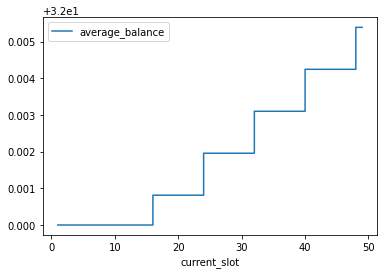

In [36]:
df.plot("current_slot", "average_balance")

It increases! Validators are behaving well, the network latency is small enough that no message is delayed too much, it's all good.

## Arrival

So what have we done here?

- We have a group of validators who are all individually keeping track of their view of the beacon state.
- Validators are on a network and communicate with each other, keeping track of known (but perhaps unincluded) attestations and blocks.
- Whenever something changes, e.g., the beginning of a new slot/epoch or a new block/attestation received on-the-wire (as in, from the p2p network), validators update their internals to parameterise their strategies.
- Each step, the simulation pings all validators and asks whether they want to propose or attest at this point in time. Depending on their internals, validators reply with a block or an attestation.

Now that we have this nice playground for validators to roam around, we are getting close to a full-fledged _agent-based model_. But we need more agents! Who expects here that all validators will be ASAP always? And is ASAP the only "good" behaviour? Probably not!

We'll use the framework developed in this notebook to explore these questions, with a series of smaller "case studies" looking at specific questions. Note that our simulation environment is still incomplete, in that validators should do more than just proposing and attesting.

- Up until now we assumed proposers were taking on the responsibility of aggregating their known attestations to record them in their proposed blocks. In eth2, aggregators are separate entities, chosen randomly at each slot.
- We also haven't given our validators the power to slash malicious validators. With a few tweaks here and there we can do that simply enough.